In [1]:
%load_ext autoreload
%autoreload 2

# I have experienced stability issues with float32.
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from libretions.channels.fm97 import Na, K, KA, KCa, Ca, Leak

import jaxley as jx

In [3]:
from typing import List, Dict, Tuple
from jaxley.channels import Channel

def voltage_clamp(
    channels: List[Channel],
    V_hold: float,
    V_step: float,
    T_hold: int,
    T_step: int,
    dt: float
) -> Tuple[Dict[str, jnp.ndarray], Dict[str, Dict[str, List[float]]]]:
    # Initialize the global state, the dictionary for currents, and the dictionary for states
    states = {}
    channel_currents = {channel._name: [] for channel in channels}
    channel_states_history = {channel._name: {state: [] for state in channel.channel_states} for channel in channels}
    
    for channel in channels:
        states.update(channel.channel_states)

    # Function to update the states of all channels and record state history
    def update_all_channels(V, dt):
        for channel in channels:
            new_states = channel.update_states(states, dt, V, channel.channel_params)
            states.update(new_states)
            # Record the state history
            for state_key, state_value in new_states.items():
                channel_states_history[channel._name][state_key].append(state_value)

    # Function to compute and store the currents of all channels
    def store_all_currents(V):
        for channel in channels:
            current = channel.compute_current(states, V, channel.channel_params)
            channel_currents[channel._name].append(current)

    # Hold at V_hold for T_hold duration
    for _ in range(T_hold):
        update_all_channels(V_hold, dt)

    # Step to V_step and record currents for T_step duration
    for _ in range(T_step):
        update_all_channels(V_step, dt)
        store_all_currents(V_step)
    
    # Convert the lists in channel_currents and channel_states_history to jnp.ndarray
    for channel_name in channel_currents:
        channel_currents[channel_name] = jnp.array(channel_currents[channel_name])
        for state_name in channel_states_history[channel_name]:
            channel_states_history[channel_name][state_name] = jnp.array(channel_states_history[channel_name][state_name])
    
    return channel_currents, channel_states_history

# Define voltage clamp parameters
V_hold = -65.0  # mV, the holding potential
T_hold = 1000    # ms, the duration of the holding potential
T_step = 1000    # ms, the duration of the step potential
dt = 0.01        # ms, the time step for the simulation
linestyles = {
	"-40": "solid",
	"-20": "dotted",
	"0": (5, (10, 3)),
	"20": "dashed",
	"40": "dashdot",
}

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-01-19 10:19:26.212402: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



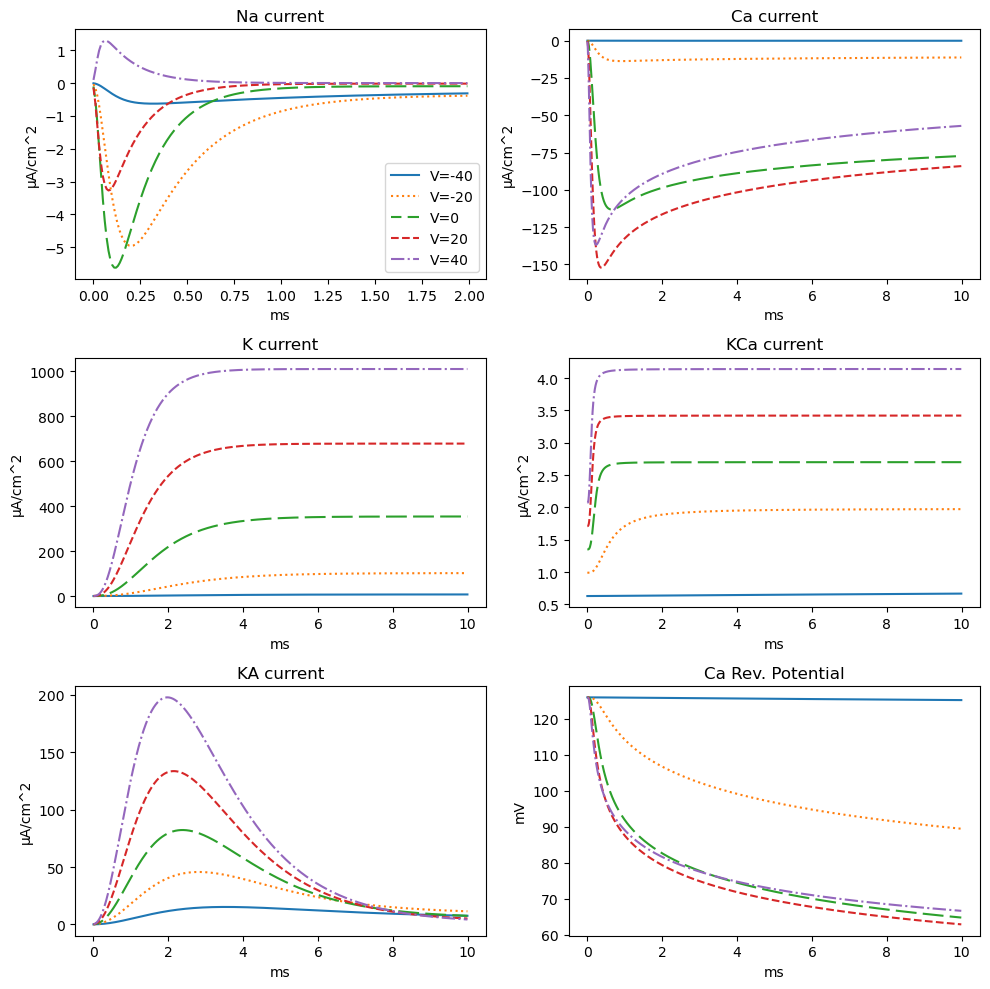

In [4]:
# Run the voltage clamp simulation
fig, ax = plt.subplots(3,2, figsize=(10,10))
ax = ax.flatten()
for V_step in [-40, -20, 0, 20, 40]:
    currents, states = voltage_clamp(
        [Na(), Ca(), K(), KCa(), KA()],
        -65,
        V_step,
        T_hold,
        T_step,
        dt
    )

    for i, key in enumerate(currents):
        if key == "Na":
            ax[i].plot(jnp.arange(T_step)[:200] * dt, currents[key][:200], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
        else:
            ax[i].plot(jnp.arange(T_step) * dt, currents[key], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
        ax[i].set_title(key + " current")
        ax[i].set_xlabel("ms")
        ax[i].set_ylabel("μA/cm^2")
    
    ax[-1].plot(jnp.arange(T_step) * dt, states["Ca"]["Ca_vCa"][T_hold:], label="vCa", linestyle=linestyles[str((V_step))])
    ax[-1].set_title("Ca Rev. Potential")
    ax[-1].set_xlabel("ms")
    ax[-1].set_ylabel("mV")
ax[0].legend()
fig.tight_layout()

Seemingly close, but not quite. The values are still a bit off compare to Fig. 1 in Fohlmeister & Miller (1997). Also, current clamp result is far from the same (no bursting at all) for now. #TODO

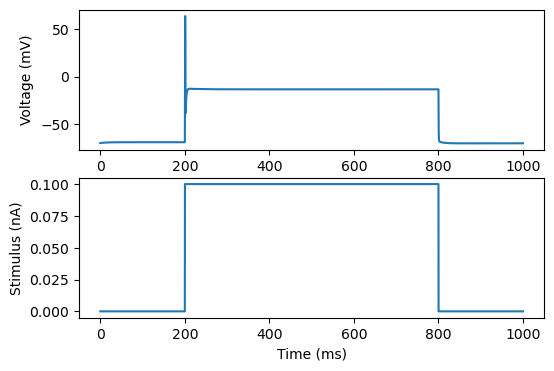

In [23]:
cell = jx.Compartment()
cell.insert(Na())
cell.insert(K())
cell.insert(KA())
cell.insert(KCa())
cell.insert(Ca())
cell.insert(Leak())

# Stimulus.
i_delay = 200.0  # ms
i_amp = 0.1  # nA 
i_dur = 600.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 0.025  # ms
t_max = 1000.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)


current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
cell.stimulate(current)
cell.record()

# run the model
s = jx.integrate(cell, delta_t=dt)

plt.figure(1,  figsize=(6, 4))
ax = plt.subplot(211)
_ = ax.plot(time_vec, s.T[:-1])
# _ = ax.set_ylim([-120, 90])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

ax = plt.subplot(212)
ax.plot(time_vec, current)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Stimulus (nA)")